# Баран, нужно исправить: обучить векторизатор, загружать и использовать в pipeline

In [35]:
# !pip install scikit-plot
# !pip install catboost

In [94]:
import sklearn
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.decomposition.pca import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics

import catboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.externals import joblib

/home/user/src/PY36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Кластеризация обращения граждан по категориям

In [ ]:
# Для задачи кластеризации будут испоьзованы седующие алгоритмы:
# KMeans - 
# MiniBatchKMeans - 
# SpectralClustering - 
# Так как задачи кластеризации вычислительно сложны и ресурсоемки, будем использовать алгоритмы понижения размерности
# Обоснование
# 
# 
# 

In [3]:
# Загружаем данные
try:
    df = pd.read_csv('../Session2/category.csv')
except Exception as ex:
    print(ex)

In [4]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,category
0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,благоустройство территории
1,1,0.0,0.236492,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,благоустройство территории
2,2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,содержание и ремонт муниципальных дорог
3,3,0.0,0.000000,0.0,0.0,0.0,0.303421,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,благоустройство территории
4,4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,содержание и ремонт муниципальных дорог


In [5]:
# Делим исходный набор на тестовую и тренировочную

In [6]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:, 1:-1], df.category, test_size=0.33)

In [7]:
train_x.shape, train_y.shape

((14064, 500), (14064,))

In [8]:
# Обучим модель понижения размерности PCA для преобразования признаков из исходной размерности в меньшее. Это поможет повысить скорость обучения моделей почти не изменяя точность

<AxesSubplot:title={'center':'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

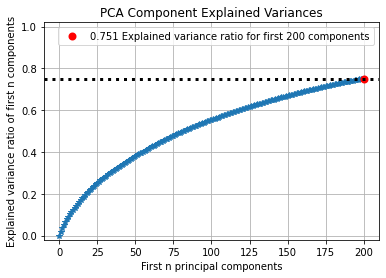

In [13]:
pca = PCA(random_state=2022, n_components=200)
pca.fit(train_x)
skplt.decomposition.plot_pca_component_variance(pca)

In [15]:
print('train_x.shape', train_x.shape)
print('pca.transform(train_x).shape', pca.transform(train_x).shape)

train_x.shape (14064, 500)
pca.transform(train_x).shape (14064, 200)


In [ ]:
# Визуализируем категории обращения граждан

<AxesSubplot:title={'center':'PCA 2-D Projection'}, xlabel='First Principal Component', ylabel='Second Principal Component'>

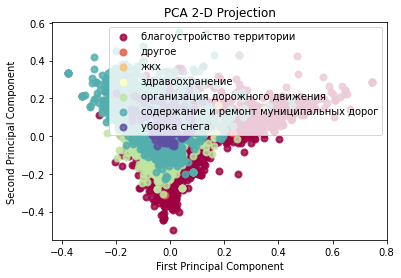

In [41]:
skplt.decomposition.plot_pca_2d_projection(pca, train_x, train_y)

In [ ]:
# Обучим первую модель KMeans

In [16]:
kmeans = KMeans(n_clusters=len(pd.unique(df.category)), random_state=True)
kmeans.fit(pca.transform(train_x), train_y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=True, tol=0.0001, verbose=0)

In [17]:
# Предскажем обращения пользователей

In [18]:
def pred(index):
    print(kmeans.predict(pca.transform([df.iloc[index, 1:-1].values])), df.iloc[index, -1])

In [19]:
pred(4)
pred(19799)
pred(405)
pred(5)

[1] содержание и ремонт муниципальных дорог
[1] уборка снега
[0] организация дорожного движения
[1] благоустройство территории


In [20]:
# Выведем результат работы алгоритма, измерив ее с помощью соответствующих метрик

In [21]:
def print_metrics(x, y):
    # Первая метрика
    print('homogeneity_completeness_v_measure:', 
          metrics.homogeneity_completeness_v_measure(kmeans.predict(x), y))
    # Вторая метрика
    print('adjusted_rand_score:', 
          metrics.adjusted_rand_score(kmeans.predict(x), y))

print_metrics(pca.transform(train_x), train_y)

homogeneity_completeness_v_measure: (0.1827034015146286, 0.1826446500622922, 0.18267402106456337)
adjusted_rand_score: 0.01274252697924128


In [22]:
print_metrics(pca.transform(test_x), test_y)

homogeneity_completeness_v_measure: (0.1879783138803925, 0.19064047785780797, 0.18930003669676476)
adjusted_rand_score: 0.012735868119589908


In [23]:
# Визуализируем на двумерной плоскости целевые значения и предсказанные на обученном наборе, видно, что алгоритмы работают не совсем хорошо

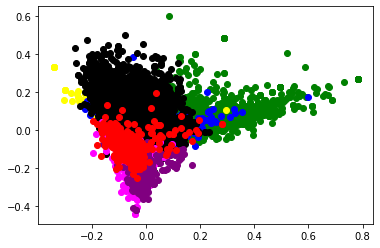

In [24]:
pca1 = PCA(n_components=2)
pca1.fit(train_x)
vis = pd.concat([pd.DataFrame(pca1.transform(train_x)), pd.DataFrame(kmeans.predict(pca.transform(train_x)), columns=['t'])], axis=1)

plt.scatter(vis[vis['t']==2].iloc[:, [0]], vis[vis['t']==2].iloc[:, [1]], c='green')
plt.scatter(vis[vis['t']==3].iloc[:, [0]], vis[vis['t']==3].iloc[:, [1]], c='yellow')
plt.scatter(vis[vis['t']==4].iloc[:, [0]], vis[vis['t']==4].iloc[:, [1]], c='blue')
plt.scatter(vis[vis['t']==1].iloc[:, [0]], vis[vis['t']==1].iloc[:, [1]], c='black')
plt.scatter(vis[vis['t']==6].iloc[:, [0]], vis[vis['t']==6].iloc[:, [1]], c='magenta')
plt.scatter(vis[vis['t']==5].iloc[:, [0]], vis[vis['t']==5].iloc[:, [1]], c='purple')
plt.scatter(vis[vis['t']==0].iloc[:, [0]], vis[vis['t']==0].iloc[:, [1]], c='red')

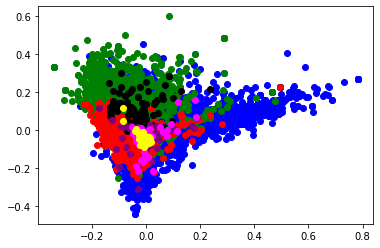

In [25]:
vis = pd.concat([pd.DataFrame(pca1.transform(train_x)), pd.DataFrame(train_y.values, columns=['t'])], axis=1)
l = vis['t'].value_counts().index.tolist()

plt.scatter(vis[vis['t']==l[0]].iloc[:, [0]], vis[vis['t']==l[0]].iloc[:, [1]], c='blue')
plt.scatter(vis[vis['t']==l[1]].iloc[:, [0]], vis[vis['t']==l[1]].iloc[:, [1]], c='green')
plt.scatter(vis[vis['t']==l[2]].iloc[:, [0]], vis[vis['t']==l[2]].iloc[:, [1]], c='red')
plt.scatter(vis[vis['t']==l[4]].iloc[:, [0]], vis[vis['t']==l[4]].iloc[:, [1]], c='black')
plt.scatter(vis[vis['t']==l[5]].iloc[:, [0]], vis[vis['t']==l[5]].iloc[:, [1]], c='purple')
plt.scatter(vis[vis['t']==l[6]].iloc[:, [0]], vis[vis['t']==l[6]].iloc[:, [1]], c='magenta')
plt.scatter(vis[vis['t']==l[3]].iloc[:, [0]], vis[vis['t']==l[3]].iloc[:, [1]], c='yellow')

In [26]:
# Обучим следующие алгоритмы кластеризации и отобразим их точность: 1)SpectralClustering 2)MiniBatchKMeans

In [27]:
def pred(model, index):
    print(model.fit_predict(pca.transform([df.iloc[index, 1:-1].values])), df.iloc[index, -1])

    
def print_metrics(model, x, y):
    print('homogeneity_completeness_v_measure:', 
          metrics.homogeneity_completeness_v_measure(model.fit_predict(pca.transform(x)), y))
    print('adjusted_rand_score:', 
          metrics.adjusted_rand_score(model.fit_predict(pca.transform(x)), y))



sprctral = SpectralClustering(n_clusters=len(pd.unique(df.category)))
sprctral.fit(pca.transform(train_x), train_y)
# pred(sprctral, 4)
# pred(sprctral, 19799)
# pred(sprctral, 405)
# pred(sprctral, 5)
print_metrics(sprctral, train_x, train_y)
print_metrics(sprctral, test_x, test_y)

homogeneity_completeness_v_measure: (0.17137394490615065, 0.2484420738617935, 0.2028340814784165)
adjusted_rand_score: 0.10555230702241204
homogeneity_completeness_v_measure: (0.16366630955584352, 0.2326415083350576, 0.1921515317125823)
adjusted_rand_score: 0.06387044978455171


In [28]:
def pred(model, index):
    print(model.predict(pca.transform([df.iloc[index, 1:-1].values])), df.iloc[index, -1])

    
def print_metrics(model, x, y):
    print('homogeneity_completeness_v_measure:', 
          metrics.homogeneity_completeness_v_measure(model.predict(pca.transform(x)), y))
    print('adjusted_rand_score:', 
          metrics.adjusted_rand_score(model.predict(pca.transform(x)), y))
    
    

shift = MiniBatchKMeans(n_clusters=len(pd.unique(df.category)))
shift.fit(pca.transform(train_x), train_y)
print_metrics(shift, train_x, train_y)
print_metrics(shift, test_x, test_y)

homogeneity_completeness_v_measure: (0.12845517148738647, 0.17510753869056972, 0.14819652188534652)
adjusted_rand_score: 0.12192083869090696
homogeneity_completeness_v_measure: (0.13592931065620228, 0.18389328483590756, 0.15631470567980082)
adjusted_rand_score: 0.1317480241184369


In [ ]:
# Лучше всех себя показала SpectralClustering

# Классификация обращений граждан по категориям

In [31]:
# Загружаем данные
try:
    df = pd.read_csv('../Session2/category.csv')
except Exception as ex:
    print(ex)

In [32]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,category
0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,благоустройство территории
1,1,0.0,0.236492,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,благоустройство территории
2,2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,содержание и ремонт муниципальных дорог
3,3,0.0,0.000000,0.0,0.0,0.0,0.303421,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,благоустройство территории
4,4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,содержание и ремонт муниципальных дорог


In [41]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:, 1:-1], df.category, 
                                                    test_size=0.33, stratify=df.category)
train_x, valid_x, train_y, valid_y = train_test_split(df.iloc[:, 1:-1], df.category, 
                                                    test_size=0.33, stratify=df.category)

In [ ]:
# Catboost, meterics vis: roc-auc, 

In [54]:
model = catboost.CatBoostClassifier(
    boosting_type='Ordered',
    custom_metric=['AUC', 'F1'],
    eval_metric='AUC'
)

model.fit(train_x, train_y, eval_set=(valid_x, valid_y), plot=True, verbose=False)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
# Разработаем функцию для вывода метрик на экран

In [58]:
def print_metrics(model, test, y):
    print(metrics.classification_report(model.predict(test), y))

In [59]:
# метрики на тренировочной выборке, валидационной, тестовой

In [60]:
print_metrics(model, train_x, train_y)

                                         precision    recall  f1-score   support

             благоустройство территории       0.92      0.88      0.90      8259
                                 другое       0.61      0.84      0.70        95
                                    жкх       0.16      0.76      0.27        25
                        здравоохранение       0.80      0.91      0.85       116
         организация дорожного движения       0.83      0.91      0.87      1054
содержание и ремонт муниципальных дорог       0.84      0.84      0.84      4467
                           уборка снега       0.34      0.90      0.49        48

                               accuracy                           0.87     14064
                              macro avg       0.64      0.86      0.70     14064
                           weighted avg       0.88      0.87      0.87     14064



In [61]:
print_metrics(model, valid_x, valid_y)

                                         precision    recall  f1-score   support

             благоустройство территории       0.88      0.84      0.86      4071
                                 другое       0.34      0.73      0.46        30
                                    жкх       0.19      0.79      0.31        14
                        здравоохранение       0.68      0.79      0.73        56
         организация дорожного движения       0.76      0.85      0.80       509
содержание и ремонт муниципальных дорог       0.77      0.77      0.77      2232
                           уборка снега       0.24      0.94      0.38        16

                               accuracy                           0.82      6928
                              macro avg       0.55      0.81      0.62      6928
                           weighted avg       0.83      0.82      0.82      6928



In [62]:
print_metrics(model, test_x, test_y)

                                         precision    recall  f1-score   support

             благоустройство территории       0.90      0.86      0.88      4067
                                 другое       0.62      0.93      0.74        43
                                    жкх       0.18      0.83      0.29        12
                        здравоохранение       0.78      0.85      0.82        60
         организация дорожного движения       0.80      0.89      0.84       519
содержание и ремонт муниципальных дорог       0.81      0.81      0.81      2212
                           уборка снега       0.22      0.93      0.36        15

                               accuracy                           0.85      6928
                              macro avg       0.62      0.87      0.68      6928
                           weighted avg       0.86      0.85      0.85      6928



In [ ]:
# Визулизируем метрики

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

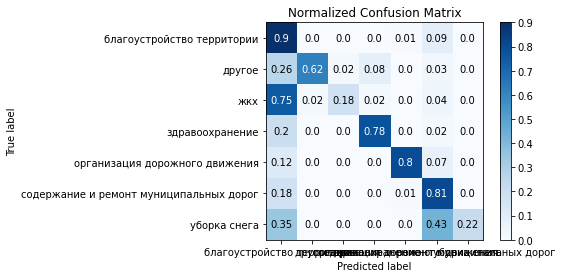

In [68]:
skplt.metrics.plot_confusion_matrix(test_y, model.predict(test_x), normalize=True)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

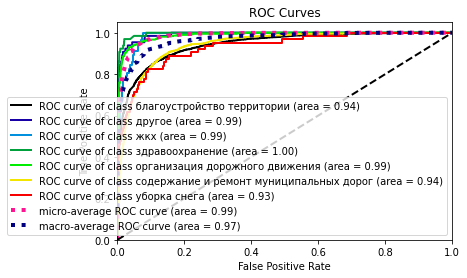

In [69]:
skplt.metrics.plot_roc(test_y, model.predict_proba(test_x))

In [ ]:
# Logistic regression, grid_search, cross_val

In [ ]:
# Так как логистическая регрессия менее вычислительно затратная, применим ее для 
# кросс-валидации и поиска по сетке

In [ ]:
model = LogisticRegression()
param = {}
grid_search = GridSearchCV()
grid_search.fit(train_x, train_y)

In [ ]:
# Random forest, learning_curve, feature_importance

/home/user/src/PY36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

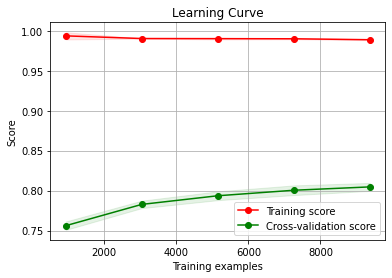

In [75]:
model = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    n_jobs=-1,
    class_weight='balanced'
)
skplt.estimators.plot_learning_curve(model, train_x, train_y)

In [ ]:
model.fit(train_x, train_y)

<AxesSubplot:title={'center':'Feature Importance'}>

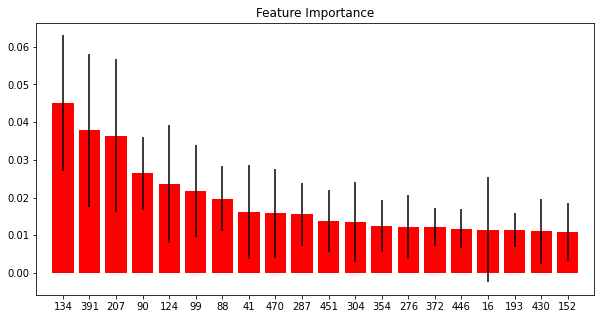

In [91]:
skplt.estimators.plot_feature_importances(model, figsize=(10, 5))

In [ ]:
# Было бы круто перевести индекс в слово

In [92]:
# Вывод метрик
print_metrics(model, test_x, test_y)

                                         precision    recall  f1-score   support

             благоустройство территории       0.93      0.94      0.94      3836
                                 другое       0.77      0.42      0.55       118
                                    жкх       0.74      1.00      0.85        42
                        здравоохранение       0.95      0.90      0.93        69
         организация дорожного движения       0.91      0.93      0.92       558
содержание и ремонт муниципальных дорог       0.91      0.90      0.90      2260
                           уборка снега       0.71      1.00      0.83        45

                               accuracy                           0.92      6928
                              macro avg       0.85      0.87      0.85      6928
                           weighted avg       0.92      0.92      0.92      6928



In [93]:
print_metrics(model, train_x, train_y)

                                         precision    recall  f1-score   support

             благоустройство территории       0.98      1.00      0.99      7775
                                 другое       1.00      0.53      0.69       248
                                    жкх       0.99      0.99      0.99       116
                        здравоохранение       0.99      1.00      1.00       131
         организация дорожного движения       0.99      0.99      0.99      1163
содержание и ремонт муниципальных дорог       0.99      0.99      0.99      4503
                           уборка снега       1.00      1.00      1.00       128

                               accuracy                           0.99     14064
                              macro avg       0.99      0.93      0.95     14064
                           weighted avg       0.99      0.99      0.99     14064



In [95]:
# Сохраним модель
joblib.dump(model, 'rf_model.pkl')

['rf_model.pkl']

In [97]:
m = joblib.load('rf_model.pkl')
m.score(test_x, test_y)

0.9187355658198614

# Классификация обращений по ведомствам

# Семантический анализ обращений